# Analysis of Lending Club Data

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
import pandas as pd
import os, sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context(rc={
       "figure.figsize": (16, 10),
       "axes.titlesize": 14})

from collections import defaultdict
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import SGDClassifier as SGDClf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer

from os.path import expanduser
sys.path.insert(1, '{}/datsci'.format(expanduser('~')))
from datsci import eda, ml

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

# Data Source

LendingClub 2015 data

Downloaded loan data from https://www.lendingclub.com/info/download-data.action

In [3]:
ls

BondStreetDataAggregator.pdf  analysis.ipynb
Code Test Guidelines.pdf      data/


In [4]:
ls data/

LCDataDictionary.xlsx    LoanStats3d.csv*         ~$LCDataDictionary.xlsx


In [5]:
# Read in raw data
df = pd.read_csv(open('data/LoanStats3d.csv', 'r'), low_memory=False, skiprows=1).head(421095)

In [6]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68516507,73406314.0,14000.0,14000.0,14000.0,36 months,9.80%,450.43,B,B3,...,0.0,2.0,100.0,0.0,0.0,0.0,531602.0,84039.0,34500.0,55842.0
1,68587652,73477494.0,25000.0,25000.0,25000.0,36 months,5.32%,752.87,A,A1,...,0.0,1.0,100.0,0.0,0.0,0.0,512381.0,44786.0,44000.0,51081.0
2,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
3,68416935,73306760.0,15000.0,15000.0,15000.0,36 months,9.80%,482.61,B,B3,...,0.0,4.0,100.0,0.0,1.0,0.0,347470.0,53397.0,36100.0,47370.0
4,68357012,73246847.0,15000.0,15000.0,15000.0,36 months,8.49%,473.45,B,B1,...,0.0,4.0,100.0,20.0,1.0,0.0,369112.0,27849.0,28200.0,21124.0


# Preprocessing
## Filtering for small business loans data

"Title" vs "Purpose"

There are overlaps between `df.purpose = small_business` and `df.title = Business`
According to the LCDataDictionary.xlsx, `purpose` is defined as 'A category provided by the borrower for the loan request.' and `title` is defined as `The loan title provided by the borrower`.

In [7]:
# Want "small_business"
df.purpose.drop_duplicates()

0                    medical
1                credit_card
3         debt_consolidation
5           home_improvement
6                      other
14                       car
15            major_purchase
19            small_business
25                     house
55                  vacation
371                   moving
2471        renewable_energy
164525               wedding
323800           educational
Name: purpose, dtype: object

In [8]:
# Want "Business", 
df.title.drop_duplicates()

0                                Medical expenses
1                         Credit card refinancing
3                              Debt consolidation
5                                Home improvement
6                                           Other
14                                  Car financing
15                                 Major purchase
19                                       Business
22                                            NaN
25                                    Home buying
55                                       Vacation
371                         Moving and relocation
2471                                   Green loan
73524                                     odymeds
111721                                       SAVE
323800                      Learning and training
336598                                    new day
340818            Trying to come back to reality!
343869                                considerate
355967    Paying off higher interest cards & auto


In [9]:
df_purpose_small_business = df[df.purpose == 'small_business']
df_purpose_small_business.shape

(3364, 111)

In [10]:
df_title_business = df[df.title == "Business"]
df_title_business.shape

(3357, 111)

In [11]:
len(set(df_purpose_small_business.id).intersection(set(df_title_business.id)))

3346

In [12]:
len(set(df_title_business.id) - set(df_purpose_small_business.id))

11

In [13]:
len(set(df_purpose_small_business.id) - set(df_title_business.id))

18

In [14]:
df_purpose_small_business.title.drop_duplicates()

19                       Business
5066                          NaN
63524          Debt consolidation
64956                       Other
124445    Credit card refinancing
177113                   Vacation
211557              Car financing
Name: title, dtype: object

In [15]:
df_title_business.purpose.drop_duplicates()

19            small_business
66465            credit_card
96152                  other
124486    debt_consolidation
336419      home_improvement
Name: purpose, dtype: object

In [16]:
# Just take union of the two data sets for now
df = df[(df.title == "Business") | (df.purpose == 'small_business')]

In [17]:
# Remove the columns
df.drop(['title','purpose'], 1, inplace=True)

## Target variable

`loan_status` is the current status of the loan

Set "Default", "Charged Off" and "Late (31-120 days)" as 0 to indicate bad loans

According to [LendingClub website](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-), grace period is 15 days, so it's not overdue - Consider later on set it at some value between 0 and 1 to indicate that it's risky?

Set "Late (31-120 days)" as still okay, since less than 90

In [18]:
df.loan_status.drop_duplicates()

19                  Current
105              Fully Paid
1164     Late (31-120 days)
1934                Default
9944        In Grace Period
11056           Charged Off
34822     Late (16-30 days)
Name: loan_status, dtype: object

In [19]:
def get_target_value(val):
    if val in {'Late (31-120 days)', 'Default', 'Charged Off'}:
        return 0.0
    return 1.0

df['loan_status'] =  df.loan_status.apply(get_target_value)

In [20]:
# Imbalanced classes
df.loan_status.value_counts()

1.0    2968
0.0     407
Name: loan_status, dtype: int64

## Convert dtypes

In [21]:
# Convert interest rate to float
df.int_rate = pd.Series(df.int_rate).str.replace('%', '').astype(float)

## Drop columns

In [22]:
# Loan listing id and member_id are probably not useful
df[['id','member_id']].head()
df.drop(['id','member_id'], 1, inplace=True)

In [23]:
# Remove emp_title, since it'd be hard to automate taking this into account
df.emp_title.drop_duplicates().shape
df.drop(['emp_title'], 1, inplace=True)

In [24]:
# More uninformative columns
# Drop `pymnt_plan` - indicates if user is currently on a payment plan, possibly after overdue
# Drop url - uninformative
# Drop desc - uninformative text
df[['pymnt_plan', 'url', 'desc']].head()

,pymnt_plan,url,desc
19,n,https://lendingclub.com/browse/loanDetail.acti...,NaN
105,n,https://lendingclub.com/browse/loanDetail.acti...,NaN
512,n,https://lendingclub.com/browse/loanDetail.acti...,NaN
606,n,https://lendingclub.com/browse/loanDetail.acti...,NaN
763,n,https://lendingclub.com/browse/loanDetail.acti...,NaN


In [25]:
df['desc'].drop_duplicates().shape

(3,)

In [26]:
df.drop(['pymnt_plan','url','desc'], 1, inplace=True)

In [27]:
# earliest_cr_line - delete for now
# might be interesting down the road to see if there is a relationship between the time between now and the first loan, and the default rate
# Are we considering returning businesses?
df.earliest_cr_line.head()
df.drop(['earliest_cr_line'], 1, inplace=True)

In [28]:
# Drop initial_list_status - Lending Club domain specific - one lender vs multiple lenders?
print(df.initial_list_status.drop_duplicates())
df.drop(['initial_list_status'], 1, inplace=True)

19      w
1595    f
Name: initial_list_status, dtype: object


In [29]:
# Remove `revol_util` - domain specific?
df.drop(['revol_util'], 1, inplace=True)

# Remove `emp_length`? - is this pertinent to business loans? might be more pertinent to personal loans...
df.drop(['emp_length'], 1, inplace=True)

# Remove income `verification_status` - may be pertinent to personal loans only, though maybe there is a way to verify business revenue
df.drop(['verification_status'], 1, inplace=True)

# Remove `issue_d` - Does it matter when the loan was issued?
df.drop(['issue_d'], 1, inplace=True)

# Remove location information for now
df.drop(['zip_code', 'addr_state'], 1, inplace=True)

In [30]:
df.application_type.value_counts()

INDIVIDUAL    3373
JOINT            2
Name: application_type, dtype: int64

In [31]:
# Remove application_type
df.drop(['application_type'], 1, inplace=True)

In [32]:
# Remove attributes available after loan was granted
df.drop(['out_prncp', 'funded_amnt', 'term', 'int_rate', 'installment', 'home_ownership', 'funded_amnt_inv', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv','total_rec_prncp', 'grade', 'sub_grade',
         'total_rec_int','total_rec_late_fee', 'recoveries','collection_recovery_fee', 'collection_recovery_fee',
         'last_pymnt_d','last_pymnt_amnt', 'next_pymnt_d','last_credit_pull_d'], 1, inplace=True)

In [33]:
df.verification_status_joint.drop_duplicates()

19               NaN
9815    Not Verified
Name: verification_status_joint, dtype: object

In [34]:
df.verification_status_joint.value_counts(dropna=False)

NaN             3373
Not Verified       2
Name: verification_status_joint, dtype: int64

In [35]:
# Don't know what that is, but seems uninformative
df.drop(['verification_status_joint'], 1, inplace=True)

In [36]:
# Find columns that have the same value all the way
eda.find_const_cols(df)

['policy_code']

In [37]:
df.drop(eda.find_const_cols(df), 1, inplace=True)

In [38]:
# Find columns with too many null values
eda.find_null_cols(df, frac=.8)

['annual_inc_joint',
 'dti_joint',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [39]:
df.drop(eda.find_null_cols(df, frac=.8), 1, inplace=True)

In [40]:
eda.summarize_nulls(df, df)

Num train samples: 3375
Num test samples: 3375


,Column,Null Train,% Train,Null Test,% Test
0,mths_since_last_delinq,1442,42.725926,1442,42.725926
1,mths_since_last_record,2561,75.881481,2561,75.881481
2,mths_since_last_major_derog,2185,64.740741,2185,64.740741
3,bc_open_to_buy,37,1.096296,37,1.096296
4,bc_util,41,1.214815,41,1.214815
5,mo_sin_old_il_acct,131,3.881481,131,3.881481
6,mths_since_recent_bc,38,1.125926,38,1.125926
7,mths_since_recent_bc_dlq,2375,70.370370,2375,70.370370
8,mths_since_recent_inq,230,6.814815,230,6.814815
9,mths_since_recent_revol_delinq,2045,60.592593,2045,60.592593


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3375 entries, 19 to 420985
Data columns (total 55 columns):
loan_amnt                         3375 non-null float64
annual_inc                        3375 non-null float64
loan_status                       3375 non-null float64
dti                               3375 non-null float64
delinq_2yrs                       3375 non-null float64
inq_last_6mths                    3375 non-null float64
mths_since_last_delinq            1933 non-null float64
mths_since_last_record            814 non-null float64
open_acc                          3375 non-null float64
pub_rec                           3375 non-null float64
revol_bal                         3375 non-null float64
total_acc                         3375 non-null float64
collections_12_mths_ex_med        3375 non-null float64
mths_since_last_major_derog       1190 non-null float64
acc_now_delinq                    3375 non-null float64
tot_coll_amt                      3375 non-null flo

## Filling in missing values

In [42]:
df.shape

(3375, 55)

In [43]:
df.dropna().shape

(162, 55)

In [44]:
# Just fill null values with zeros for now
df.fillna(0, inplace=True)

# Analyze 

Distribution of target classes

In [45]:
df.loan_status.value_counts()

1.0    2968
0.0     407
Name: loan_status, dtype: int64

Correlation matrix

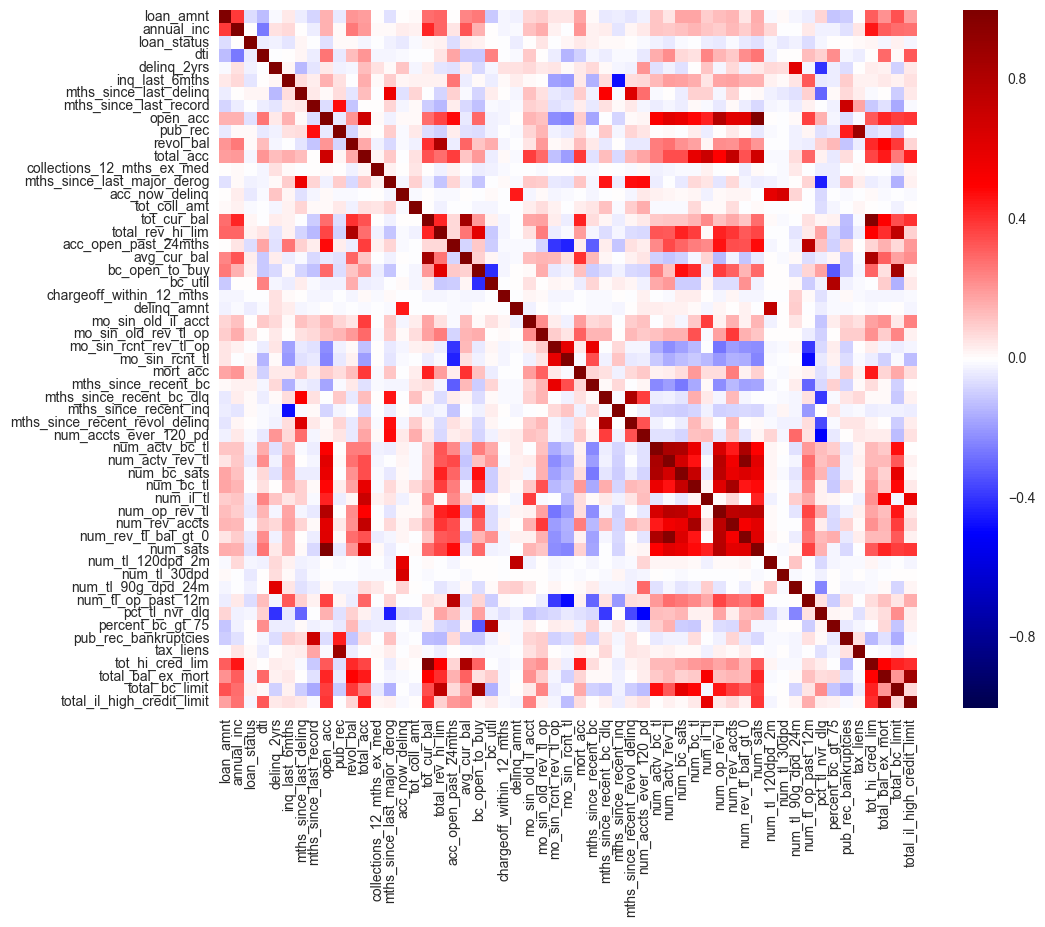

In [46]:
corr, ax = eda.corr_heat(df)

In [47]:
corr

,loan_amnt,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
loan_amnt,1.000000,0.384235,-0.066729,-0.125978,-0.015521,0.046206,-0.031288,-0.079490,0.154762,-0.046559,...,-0.018419,-0.037533,0.080409,-0.113262,-0.097156,-0.000072,0.315020,0.213028,0.341758,0.185342
annual_inc,0.384235,1.000000,0.005390,-0.261480,0.057285,0.073574,0.005830,-0.033226,0.153799,0.012374,...,-0.001319,0.040796,-0.024226,-0.028113,-0.058918,0.047085,0.453207,0.316668,0.288628,0.280718
loan_status,-0.066729,0.005390,1.000000,-0.034918,-0.026391,-0.050084,0.019527,-0.007654,-0.060739,0.014376,...,-0.030214,-0.069750,-0.021556,0.001563,0.003119,0.015226,0.023394,-0.019542,0.024186,-0.017912
dti,-0.125978,-0.261480,-0.034918,1.000000,-0.007293,0.002653,0.019890,-0.032599,0.272672,-0.044610,...,0.002875,0.128173,0.092955,0.225570,-0.022645,-0.037017,0.006640,0.294674,0.012404,0.324518
delinq_2yrs,-0.015521,0.057285,-0.026391,-0.007293,1.000000,0.016047,-0.134978,-0.053045,0.045249,-0.028173,...,0.616835,-0.022160,-0.405139,-0.037429,-0.064213,0.000380,0.032278,0.026760,-0.089849,0.045195
inq_last_6mths,0.046206,0.073574,-0.050084,0.002653,0.016047,1.000000,0.065165,0.035477,0.152861,0.059433,...,0.049491,0.323820,-0.045432,-0.038099,0.096943,0.024959,0.029132,0.046179,0.027411,0.057756
mths_since_last_delinq,-0.031288,0.005830,0.019527,0.019890,-0.134978,0.065165,1.000000,0.041291,0.009964,0.068129,...,-0.056948,0.091863,-0.297056,0.007981,0.070632,0.032407,-0.014281,0.007394,-0.095507,0.040919
mths_since_last_record,-0.079490,-0.033226,-0.007654,-0.032599,-0.053045,0.035477,0.041291,1.000000,-0.070052,0.473737,...,-0.032705,0.030697,-0.001042,-0.026107,0.695582,0.172555,-0.105185,-0.058259,-0.167556,-0.010412
open_acc,0.154762,0.153799,-0.060739,0.272672,0.045249,0.152861,0.009964,-0.070052,1.000000,-0.040723,...,0.012285,0.373652,0.148743,-0.019591,-0.066380,-0.008655,0.323128,0.427533,0.375254,0.394749
pub_rec,-0.046559,0.012374,0.014376,-0.044610,-0.028173,0.059433,0.068129,0.473737,-0.040723,1.000000,...,-0.024492,0.022363,-0.059610,-0.039184,0.438132,0.887776,-0.068489,-0.043077,-0.103801,-0.004167


In [48]:
# Get column pairs that have higher correlation than 0.9
eda.most_correlated(df, thresh=0.9)

num_rev_tl_bal_gt_0  num_actv_rev_tl    0.968798
num_sats             open_acc           0.998452
tot_hi_cred_lim      tot_cur_bal        0.984163
dtype: float64

In [49]:
# Compare target column with highest correlated column
corr.loan_status.sort_values(inplace=False, ascending=False).head()

loan_status             1.000000
mo_sin_old_rev_tl_op    0.053397
mort_acc                0.043081
avg_cur_bal             0.034809
bc_open_to_buy          0.029105
Name: loan_status, dtype: float64

In [50]:
corr.loan_status.sort_values(inplace=False, ascending=False).tail()

open_acc               -0.060739
num_sats               -0.061327
acc_open_past_24mths   -0.063988
loan_amnt              -0.066729
num_tl_op_past_12m     -0.069750
Name: loan_status, dtype: float64

Correlation is low, which makes sense since the features are continuous floats, whereas target is binary

In [61]:
#df.plot(kind='scatter', x='loan_status', y='num_tl_op_past_12m')

# ML Models

In [62]:
target_col = 'loan_status'
feature_cols = list(df.columns)
feature_cols.remove('loan_status')

X_all = df[feature_cols]  # feature values for all students
y_all = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.3, random_state=555, stratify=y_all)

In [69]:
descriptions_clfs = [
#    ("SVC Linear kernel", SVC(C=1.0, kernel='linear', gamma='auto')),
#     ("SVC polynomial deg 2 kernel", SVC(C=1.0, kernel='poly', degree=2, gamma='auto')),
#     ("SVC polynomial deg 3 kernel", SVC(C=1.0, kernel='poly', degree=3, gamma='auto')),
#     ("SVC rbf kernel", SVC(C=1.0, kernel='rbf', gamma='auto')),
#     ("KNeighbors, 3 neighbors", KNC(n_neighbors=3, weights='uniform')),
#     ("LinearRegression", LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=4)),
    ("LogisticRegression", LogisticRegression(C=1.0, penalty='l2', random_state=0, multi_class='ovr', n_jobs=4))
]

In [70]:
prelim_results = ml.train_predict(descriptions_clfs, X_train, y_train, X_test, y_test, scoring='roc_auc')

In [71]:
prelim_results

,description,score_train,score_valid,time_train,time_predict_train,time_predict_valid
0,LogisticRegression,0.62283,0.585491,0.139319,0.001582,0.000837


In [84]:
model = LogisticRegression(C=1.0, penalty='l2', random_state=0, multi_class='ovr', n_jobs=4)
y_test_hat = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]

In [85]:
y_test_hat

array([ 0.95776887,  0.9091946 ,  0.88228036, ...,  0.79026707,
        0.92012545,  0.79484845])

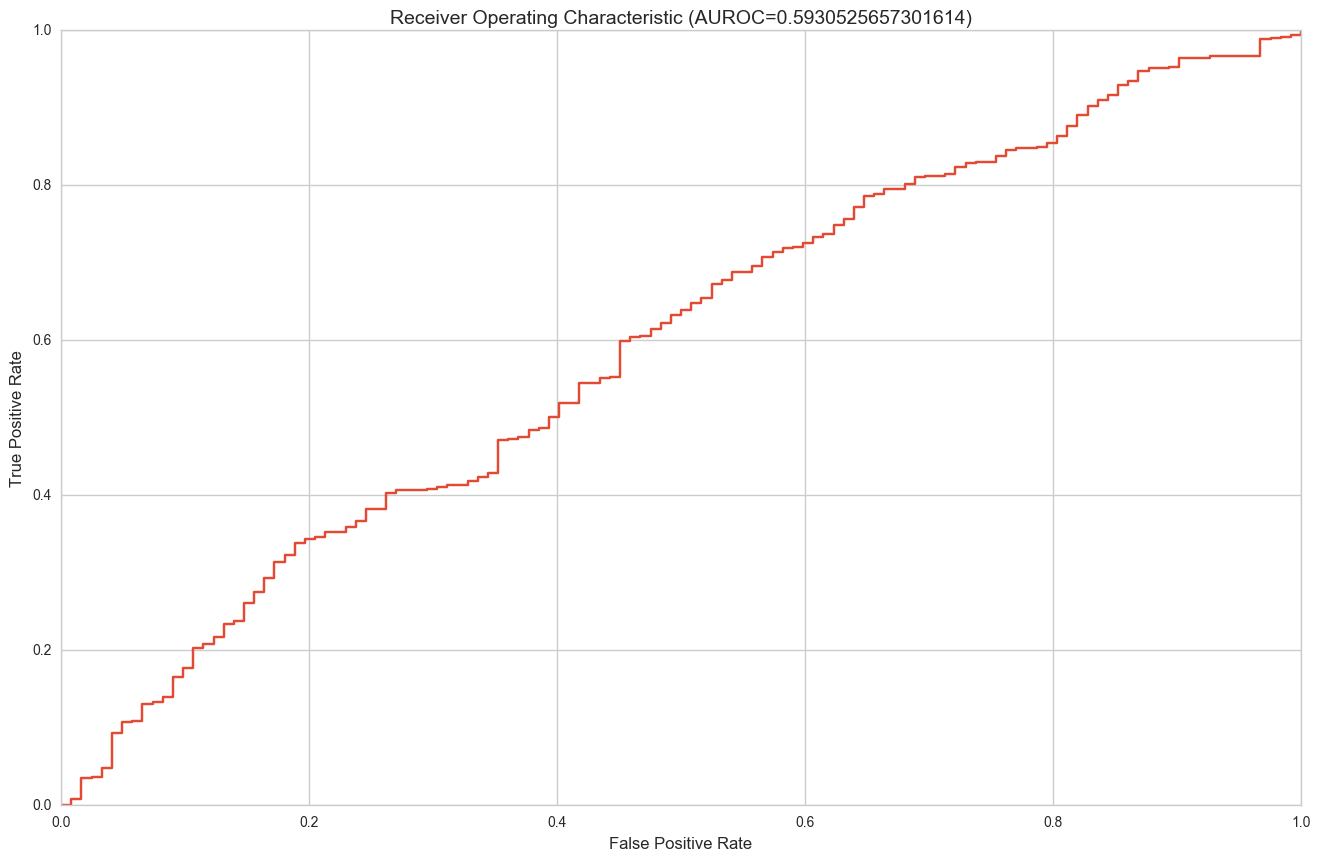

In [88]:
ml.plot_roc(y_test, y_test_hat)

# Persisting model

In [ ]:
import pickle

# Save model to disk
pickle.dump(model, open('lr.pkl', 'wb'))

# Read sklearn model in application
model2 = pickle.load(open('lr.pkl', 'rb'))

def get_score(X_new):
    """Return credit score of an application

    Parameters
    ----------
    X_new : 2-dimensional array with m rows and n columns,
        each row representing an application,
        each column representing a feature
        
        Example: [
            [x00, x01, x02, ..., x0n],
            [x10, x11, x12, ..., x1n],
            ...
            [xm0, xm1, xm2, ..., xmn]
        ]

    Returns
    -------
    1-dimensional array of size m containing predicted 
    scores for each loan application
    """
    return model2.predict_proba(X_new)[:,1]

# Difficulties
- Understanding data (what all the columns mean)
- Deciding what's relevant

# Ideas

- Configure threshold to favor false positives - have a low score threshold, and reject applications with scores below in order to automatically reject very high risk applicants
- Reduce number of features using decision trees
- Remove more uninformative columns - understand meaning behind them all
- Identify categorical features and one-hot encode them
- Tradeoff between FP and FN
- Handle missing values better
  - more meaningful substitutions
  - impute?
- XGBoost and Deep Learning models

# Reference
    https://github.com/jjinking/datsci
    https://gist.github.com/kevindavenport/998c9ec12706ab9a2ef0#file-lending_club_python-ipynb